---

In [1]:
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("/home/twhit/smc_object_detection/")
from utils.misc import select_cuda_device

device = select_cuda_device(min_free_mb=1000)

Selected device 5, which has 10820 MB available.


In [2]:
tile_dim = 8
pad = 1

num_batches = len(glob.glob("smc/counts_*.pt"))
batch_size = 20
num_images = num_batches * batch_size

prior_max_objects = 6
num_catalogs_per_count = 10000
num_catalogs = num_catalogs_per_count * (prior_max_objects + 1)

images = torch.load('../data/images.pt')[:num_images]
pruned_counts = torch.load('../data/pruned_counts.pt')[:num_images]
pruned_locs = torch.load('../data/pruned_locs.pt')[:num_images]
pruned_fluxes = torch.load('../data/pruned_fluxes.pt')[:num_images]
unpruned_counts = torch.load('../data/unpruned_counts.pt')[:num_images]
unpruned_locs = torch.load('../data/unpruned_locs.pt')[:num_images]
unpruned_fluxes = torch.load('../data/unpruned_fluxes.pt')[:num_images]

smc_unpruned_counts = torch.zeros([num_batches, batch_size, num_catalogs])
smc_unpruned_locs = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects, 2])
smc_unpruned_fluxes = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects])
smc_posterior_predictive_total_flux = torch.zeros([num_batches, batch_size, num_catalogs])
smc_runtime = torch.zeros([num_batches, batch_size])
smc_num_iters = torch.zeros([num_batches, batch_size])

for b in range(num_batches):
    smc_unpruned_counts[b] = torch.load(f'smc/counts_{b}.pt')
    smc_unpruned_locs[b] = torch.load(f'smc/locs_{b}.pt')
    smc_unpruned_fluxes[b] = torch.load(f'smc/fluxes_{b}.pt')
    smc_posterior_predictive_total_flux[b] = torch.load(f'smc/posterior_predictive_total_flux_{b}.pt')
    smc_runtime[b] = torch.load(f'smc/runtime_{b}.pt')
    smc_num_iters[b] = torch.load(f'smc/num_iters_{b}.pt')

smc_unpruned_counts = smc_unpruned_counts.flatten(0,1)
smc_unpruned_locs = smc_unpruned_locs.flatten(0,1)
smc_unpruned_fluxes = smc_unpruned_fluxes.flatten(0,1)
smc_posterior_predictive_total_flux = smc_posterior_predictive_total_flux.flatten(0,1)
smc_runtime = smc_runtime.flatten(0,1)
smc_num_iters = smc_num_iters.flatten(0,1)

In [3]:
smc_mask = torch.logical_and(smc_unpruned_locs > 0, smc_unpruned_locs < tile_dim).all(-1)
smc_pruned_counts = smc_mask.sum(-1)

smc_pruned_locs = smc_mask.unsqueeze(-1) * smc_unpruned_locs
smc_locs_mask = (smc_pruned_locs != 0).int()
smc_locs_index = torch.sort(smc_locs_mask, dim=-2, descending=True)[1]
smc_pruned_locs = torch.gather(smc_pruned_locs, dim=-2, index=smc_locs_index)

smc_pruned_fluxes = smc_mask * smc_unpruned_fluxes
smc_fluxes_mask = (smc_pruned_fluxes != 0).int()
smc_fluxes_index = torch.sort(smc_fluxes_mask, dim=-1, descending=True)[1]
smc_pruned_fluxes = torch.gather(smc_pruned_fluxes, dim=-1, index=smc_fluxes_index)

---

In [4]:
from smc.metrics import compute_tp_fn_fp, compute_precision_recall_f1

mag_bins = torch.arange(17, 24.5, 0.5)

tp, fn, fp = compute_tp_fn_fp(pruned_counts, pruned_locs, pruned_fluxes, smc_pruned_counts, smc_pruned_locs, smc_pruned_fluxes, 1000, 0.5, 0.5, mag_bins)

precision, recall, f1 = compute_precision_recall_f1(tp, fn, fp)

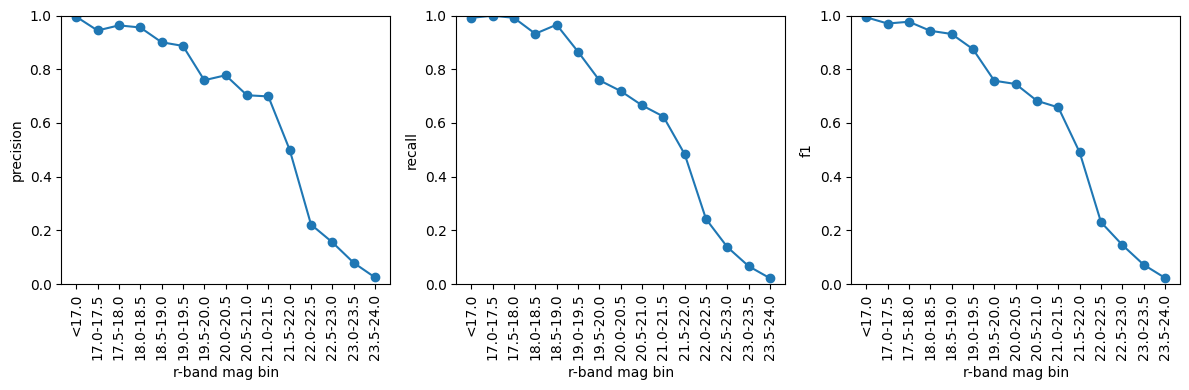

In [5]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

_ = ax[0].plot(mag_bins, precision.mean(0), "o-")
_ = ax[0].set_ylabel('precision')
_ = ax[1].plot(mag_bins, recall.mean(0), "o-")
_ = ax[1].set_ylabel('recall')
_ = ax[2].plot(mag_bins, f1.mean(0), "o-")
_ = ax[2].set_ylabel('f1')

for a in ax.flat:
    _ = a.set_xticks(ticks = mag_bins,
                   labels = [f'<{mag_bins[0]}'] + [f'{mag_bins[t].item()}-{mag_bins[t+1]}' for t in range(len(mag_bins)-1)],
                   rotation = 90)
    _ = a.set_ylim(0,1)
    _ = a.set_xlabel('r-band mag bin')

_ = fig.tight_layout()